In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os, sys
from scipy.stats import spearmanr
import sqlite3
import torch

sys.path.insert(0, '../src')
sys.path.insert(1, '..')

from main import get_model
from models.config import Config, IMAGE_TOKEN_IDS
import db_utils, visualizations, utils

/n/fs/ac-project/anaconda3/envs/vlm-lens-base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.argv = ['notebooks/get_representations.ipynb',
            '--config', '../configs/models/qwen/Qwen2-VL-2B-Instruct-VisualFlow.yaml']

config = Config()

In [3]:
print(config.modules)

[regex.Regex('visual.blocks.31', flags=regex.V0), regex.Regex('visual.merger', flags=regex.V0), regex.Regex('model.layers.27', flags=regex.V0), regex.Regex('model.norm', flags=regex.V0)]


In [3]:
model = get_model(config.architecture, config)

Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.70s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
print(model.model)


Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Seq

In [5]:
for name, module in model.model.named_modules():
    if model.config.matches_module(name):
        print(name)

visual.blocks.31
visual.merger
model.layers.27
model.norm


In [7]:
model.run(save_tokens=True)

Running forward hooks on data: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


In [6]:
db_path = model.config.output_db
utils.informal_log(db_path)
connection = sqlite3.connect(db_path)
connection.row_factory = sqlite3.Row
cursor = connection.cursor()

[1015_102511] ../output/Qwen2-VL-2B-Instruct-VisualFlow.db


In [7]:
for r in cursor.execute("""
  SELECT DISTINCT layer
  FROM tensors
"""):
    print(dict(r))

{'layer': 'input_ids'}
{'layer': 'visual.blocks.31'}
{'layer': 'visual.merger'}
{'layer': 'model.layers.27'}
{'layer': 'model.norm'}


In [10]:
for r in cursor.execute("""
  SELECT id, image_id, timestamp, name, image_path, prompt, label, layer, pooling_method, tensor_dim, tensor_shape,
         length(tensor) AS tensor_bytes
  FROM tensors
  LIMIT 20
"""):
    print(dict(r))

{'id': 1, 'image_id': None, 'timestamp': '2025-10-14 18:42:56', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': None, 'layer': 'input_ids', 'pooling_method': None, 'tensor_dim': 1, 'tensor_shape': 'torch.Size([1, 172])', 'tensor_bytes': 2524}
{'id': 2, 'image_id': None, 'timestamp': '2025-10-14 18:42:56', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': None, 'layer': 'visual.blocks.31', 'pooling_method': None, 'tensor_dim': 1280, 'tensor_shape': 'torch.Size([576, 1280])', 'tensor_bytes': 1475740}
{'id': 3, 'image_id': None, 'timestamp': '2025-10-14 18:42:56', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': No

### For each image, calculate similarity of embeddings between pairs of layers

In [8]:
module_names = []
module_embeddings = []
# Get input_ids
input_ids = db_utils.get_embeddings_by_layer(
    db_path=db_path,
    layer_name="input_ids",
    device="cuda")
input_ids, input_ids_same_shapes = db_utils.unwrap_embeddings(input_ids)

# Get embeddings for each layer
for module in config.modules:
    module_name = module.pattern
    module_embedding = db_utils.get_embeddings_by_layer(
        db_path=db_path,
        layer_name=module.pattern
    )
    module_embedding, module_embedding_same_shapes = db_utils.unwrap_embeddings(module_embedding)

    # Compute mean embedding of visual tokens only (if applicable)
    if module_name.startswith("model."):
        module_visual_embedding, n_visual_tokens = db_utils.extract_visual_embeddings(
            input_ids=input_ids,
            llm_embeddings=module_embedding,
            image_token_id=IMAGE_TOKEN_IDS[config.architecture],
            same_shapes=module_embedding_same_shapes
        )
        # Calculate mean embedding
        visual_mean_embeddings = db_utils.compute_mean_embeddings(
            embeddings=module_visual_embedding,
            n_embeddings=n_visual_tokens)
        module_names.append("{}-visual".format(module_name))
        module_embeddings.append(visual_mean_embeddings)

    # Calculate mean embedding
    mean_embeddings = db_utils.compute_mean_embeddings(
        embeddings=module_embedding)

    module_names.append(module_name)
    module_embeddings.append(mean_embeddings)

print("Layers:")
for layer in module_names:
    print("\t{}".format(layer))
n_modules = len(module_names)

# Compare embeddings across each pair of layers
comparison_names = []
cosine_sims = []
for i in range(n_modules - 1):
    for j in range(i + 1, n_modules):
        # Check embeddings are same dimensions
        embedding_i = module_embeddings[i]
        embedding_j = module_embeddings[j]
        if not embedding_i.shape == embedding_j.shape:
            continue

        name_i = module_names[i]
        name_j = module_names[j]

        # Calculate cosine sim
        cosine_sim = db_utils.cosine_similarity_numpy(embedding_i, embedding_j)
        # Only want diagonal because that is comparing same image to same image
        cosine_sim = np.diag(cosine_sim)

        comparison_names.append("{}\n\/\n{}".format(name_i, name_j))
        cosine_sims.append(cosine_sim)

Layers:
	visual.blocks.31
	visual.merger
	model.layers.27-visual
	model.layers.27
	model.norm-visual
	model.norm


3 rows; 4 columns


/n/fs/ac-vlm/vlm-lens/notebooks/../src/visualizations.py:828: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


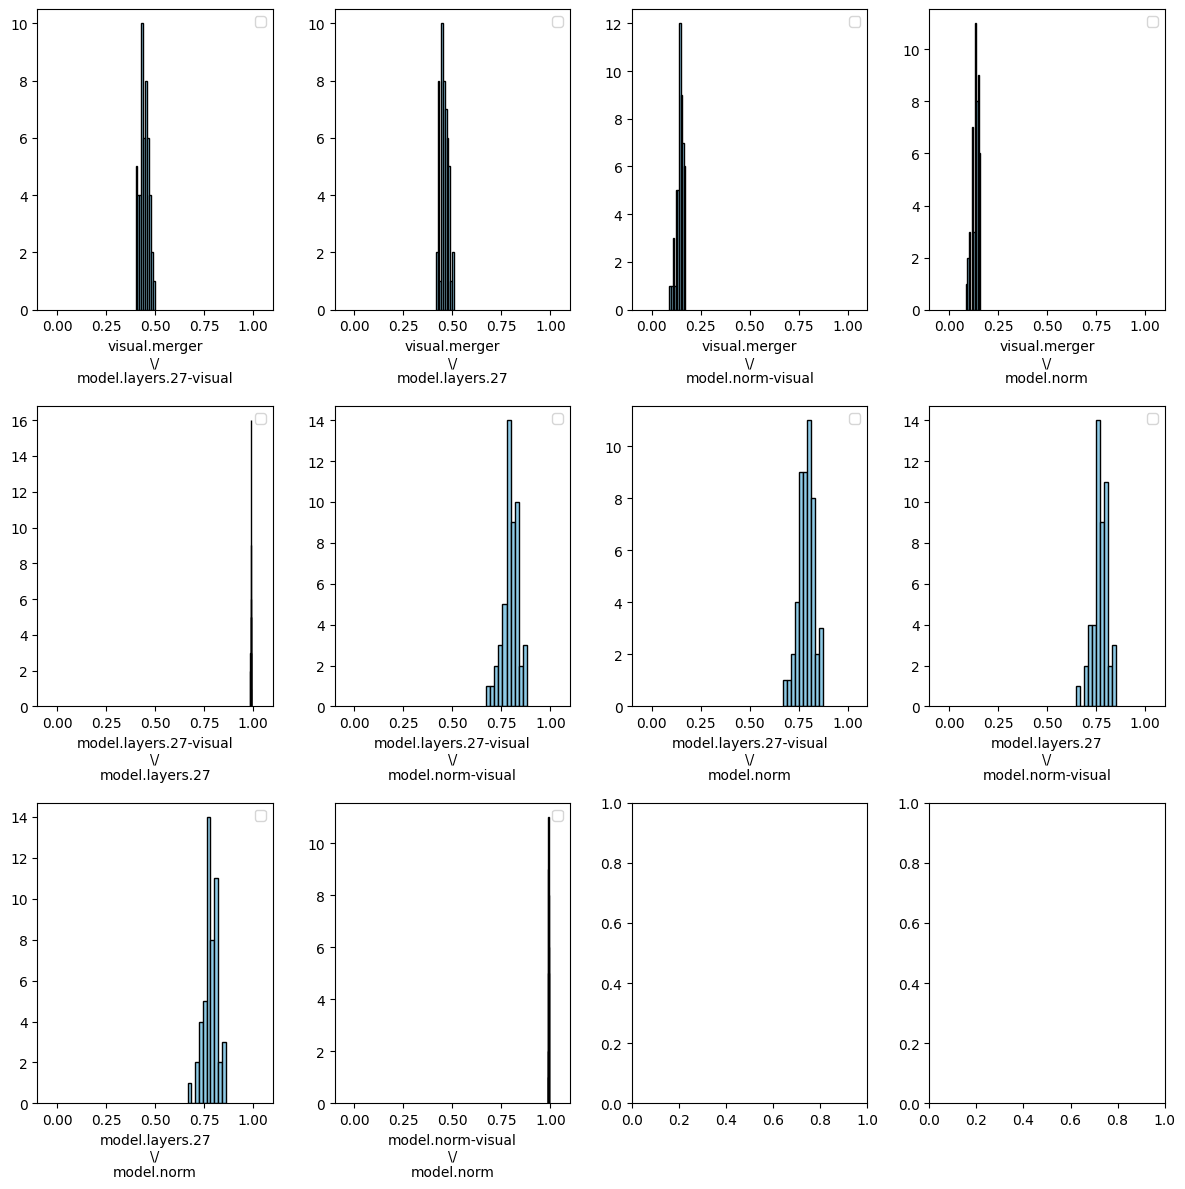

In [9]:
# Graph histograms of similarity scores for each pair of layers
n_graphs = len(comparison_names)
n_cols = 4
n_rows = n_graphs // n_cols + 1
print("{} rows; {} columns".format(n_rows, n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 4 * n_rows))

graph_idx = 0
# for idx in range(n_graphs):
for row_idx in range(n_rows):
    if graph_idx >= n_graphs:
        break
    for col_idx in range(n_cols):
        if graph_idx >= n_graphs:
            break
        if n_rows > 1:
            ax = axes[row_idx][col_idx]
        else:
            ax = axes[col_idx]
        comparison_name = comparison_names[graph_idx]
        cosine_sim = cosine_sims[graph_idx]

        fig, ax, _ = visualizations.histogram(
            data=cosine_sim,
            fig=fig,
            ax=ax,
            xlim=[-0.1, 1.1],
            xlabel=comparison_name,
            show=False
        )
        if n_rows > 1:
            axes[row_idx][col_idx] = ax
        else:
            axes[col_idx] = ax
        graph_idx += 1
plt.tight_layout()
plt.show()

### For each pair of images, calculate similarity at relevant layers

In [16]:
for name, embs in zip(module_names, module_embeddings):
    print(name, embs.shape)

visual.blocks.31 (50, 1280)
visual.merger (50, 1536)
model.layers.27-visual (50, 1536)
model.layers.27 (50, 1536)
model.norm-visual (50, 1536)
model.norm (50, 1536)


<class 'numpy.ndarray'>
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)


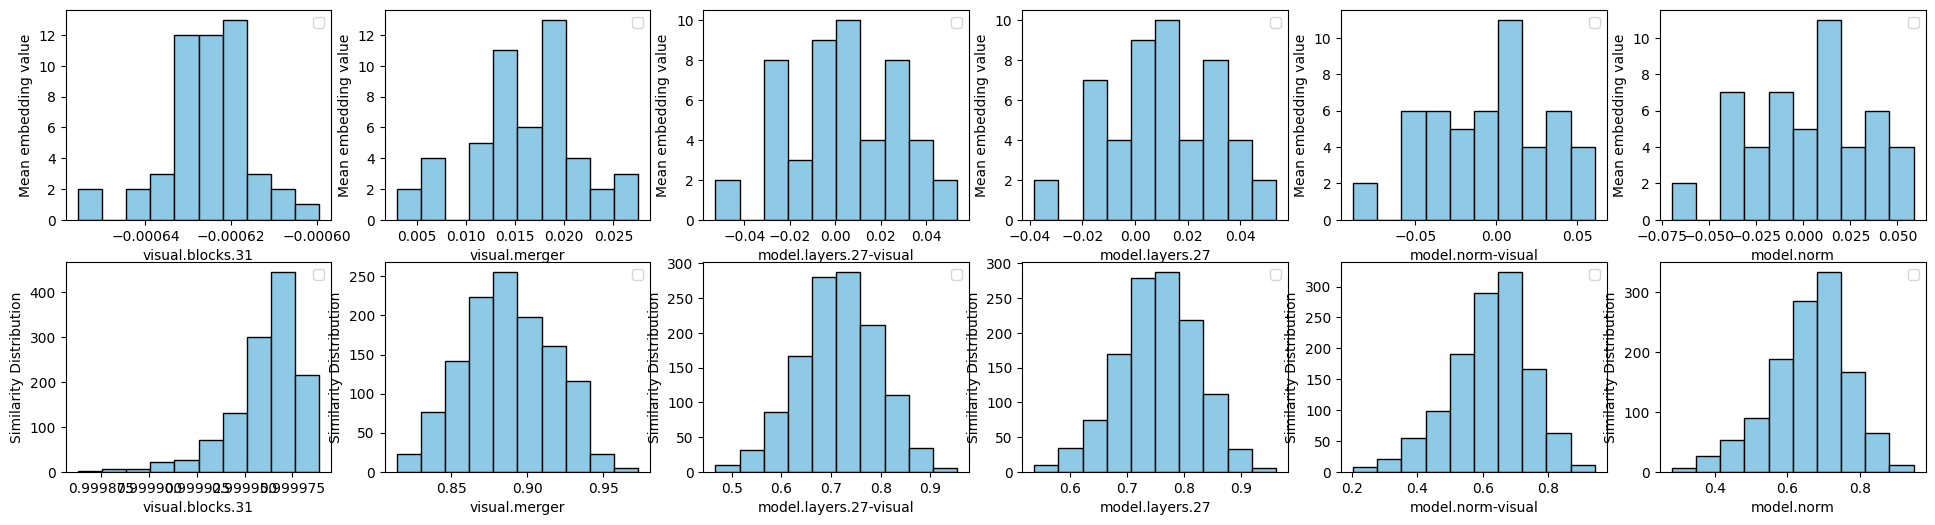

In [10]:
# For each layer get similarities
module_similarities = []
plot_histograms = True
if plot_histograms:
    fig, axes = plt.subplots(nrows=2, ncols=len(module_names), figsize=(4*len(module_names), 6))
for idx, (name, embs) in enumerate(zip(module_names, module_embeddings)):
    if name == "visual.blocks.31":
        print(type(embs))
        norm = np.linalg.norm(embs, ord=2, axis=1, keepdims=True)
        # Add epsilon to avoid division by zero
        norm = np.maximum(norm, 1e-6)

        # Divide the input array by its norm
        embs = embs / norm
    # Compute similarity with same matrix
    module_sim = db_utils.cosine_similarity_numpy(embs, embs)
    # Assert similarity is symmetric
    assert np.array_equal(module_sim, module_sim.T)

    n_samples = module_sim.shape[0]
    ut_idxs = np.triu_indices(n_samples, k=1)
    sim_values = module_sim[ut_idxs]
    assert len(sim_values) == n_samples * (n_samples - 1) / 2
    # Store values in list
    module_similarities.append(sim_values)

    if plot_histograms:
        print(np.mean(embs, axis=1).shape)
        # mean value of embeddings values
        fig, axes[0, idx], _ = visualizations.histogram(
            # sim_values.flatten(),
            np.mean(embs, axis=1),
            ylabel="Mean embedding value",
            xlabel=name,
            fig=fig,
            ax=axes[0, idx],
            show=False)

        # Similarity values
        fig, axes[1, idx], _ = visualizations.histogram(
            sim_values.flatten(),
            ylabel="Similarity Distribution",
            xlabel=name,
            fig=fig,
            ax=axes[1, idx],
            show=False)
plt.show()



15 graphs


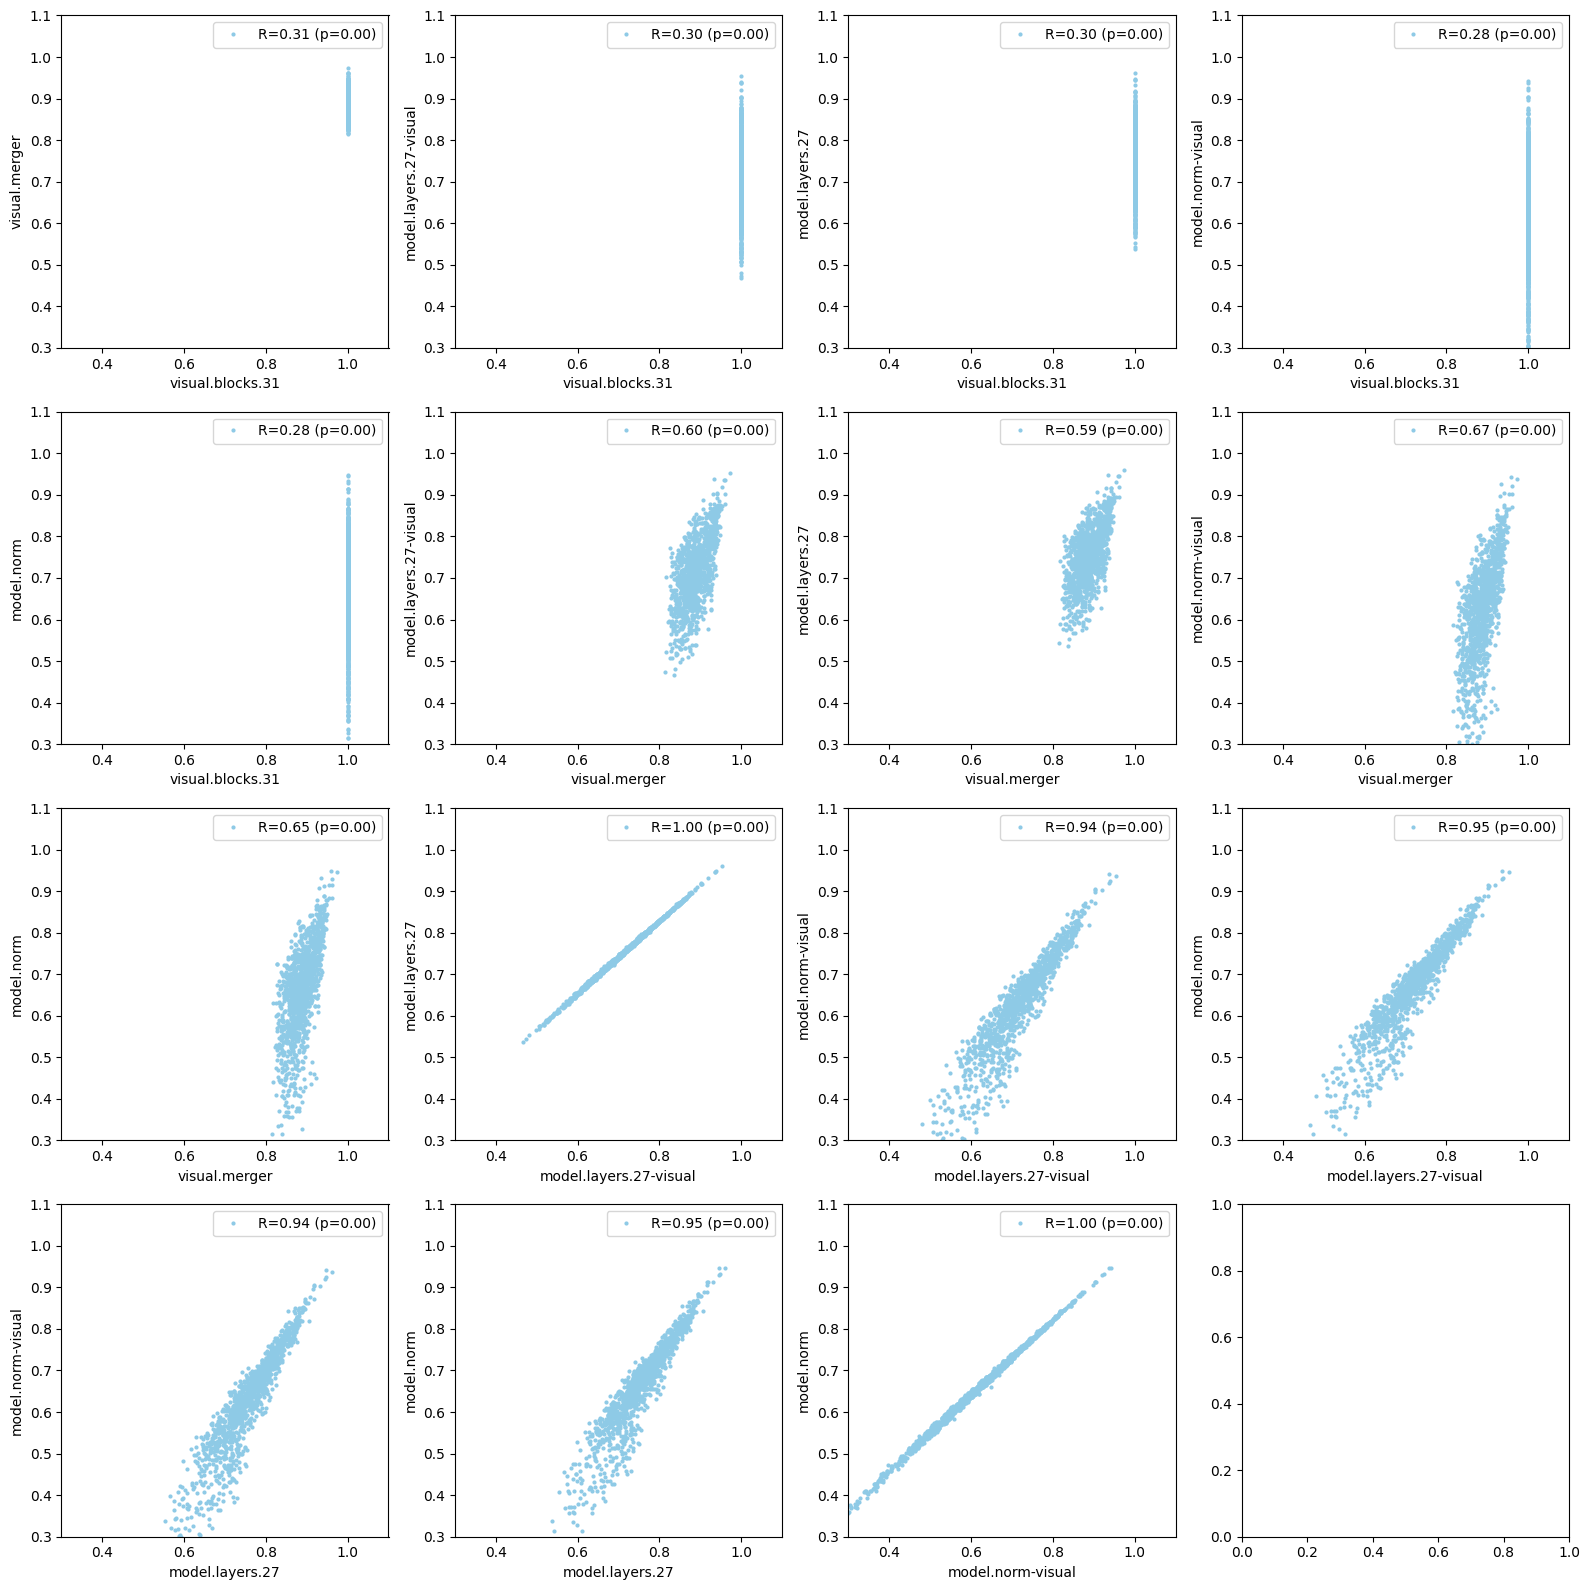

In [11]:
# Plot correlations of similarity scores between pairs of layers
n_layers = len(module_names)
n_graphs = int(n_layers * (n_layers - 1) / 2)

print("{} graphs".format(n_graphs))
n_cols = 4
n_rows = n_graphs // n_cols
if n_graphs % n_cols != 0:
    n_rows += 1
# For each pair of layers
row_idx = 0
col_idx = 0

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4 * n_cols, 4 * n_rows))
for layer_i in range(n_layers - 1):
    for layer_j in range(layer_i + 1, n_layers):
        if n_rows > 1:
            ax = axes[row_idx, col_idx]
        else:
            ax = axes[col_idx]
        name_i = module_names[layer_i]
        name_j = module_names[layer_j]

        sim_i = module_similarities[layer_i]
        sim_j = module_similarities[layer_j]

        # Calculate correlation
        corr, pval = spearmanr(sim_i, sim_j)

        fig, ax = visualizations.plot(
            fig=fig,
            ax=ax,
            xs=[sim_i],
            ys=[sim_j],
            line=False,
            marker_size=2,
            xlabel=name_i,
            ylabel=name_j,
            xlimits=[0.3, 1.1],
            ylimits=[0.3, 1.1],
            labels=['R={:.2f} (p={:.2f})'.format(corr, pval)]
        )
        if n_rows > 1:
            axes[row_idx, col_idx] = ax
        else:
            axes[col_idx] = ax

        # Update row and column idxs
        col_idx += 1
        if col_idx == n_cols:
            col_idx = 0
            row_idx += 1

plt.show()

In [ ]:
# Visualize samples that are different between visual.merger and model.norm-visual, n_visualize
layer1 = "visual.merger"
layer2 = "model.norm-visual"
n_images = len(model.config.image_paths)
print(n_images)
n_visualize = 5
modes = ["max", "min"]

# Make a dictionary keyed by names
similarities_dict = dict(zip(module_names, module_similarities))
embeddings_dict = dict(zip(module_names, module_embeddings))
# # Obtain similarity matrices

# Sanity checks
sim_matrix1 = db_utils.cosine_similarity_numpy(embeddings_dict[layer1], embeddings_dict[layer1])
sim_matrix1 = np.triu(sim_matrix1, k=1)

sim_matrix2 = db_utils.cosine_similarity_numpy(embeddings_dict[layer2], embeddings_dict[layer2])
sim_matrix2 = np.triu(sim_matrix2, k=1)

diff12 = sim_matrix1 - sim_matrix2
diff_abs = np.abs(diff12)

# Get indices with largest differences
largest_diff_idxs = np.argsort(diff_abs.flatten())[::-1][:n_visualize]
largest_diff_row_idxs, largest_diff_col_idxs = np.unravel_index(largest_diff_idxs, diff_abs.shape)
print("---Largest differences in similarity---")
for row_idx, col_idx in zip(largest_diff_row_idxs, largest_diff_col_idxs):
    print("Similarity Diff (1 - 2) ({}, {}): {:.3f})".format(row_idx, col_idx, diff12[row_idx, col_idx]))

# Make lower triangular matrix (including diagonal) 1's
lt_indices = np.tril_indices(diff_abs.shape[0], k=0)
diff_abs[lt_indices] = 2 # Out of bounds for similarity
smallest_diff_idxs = np.argsort(diff_abs.flatten())[:n_visualize]
smallest_diff_row_idxs, smallest_diff_col_idxs = np.unravel_index(smallest_diff_idxs, diff_abs.shape)
print("---Smallest differences in similarity---")
for row_idx, col_idx in zip(smallest_diff_row_idxs, smallest_diff_col_idxs):
    print("Similarity Diff (1 - 2) ({}, {}): {:.3f})".format(row_idx, col_idx, diff12[row_idx, col_idx]))

# Make lower triangular matrix (including diagonal) back to 0's
diff_abs[lt_indices] = 0

# Get list of image paths

cursor.execute("""
    SELECT image_path
    FROM tensors WHERE layer = ?
    """, (layer1,))

image_paths = cursor.fetchall()
# for result in results:
#     print(result[0])
image_paths = [str(path[0]) for path in image_paths]
print(image_paths)


50
---Largest differences in similarity---
Similarity Diff (1 - 2) (14, 23): 0.653)
Similarity Diff (1 - 2) (14, 37): 0.630)
Similarity Diff (1 - 2) (23, 24): 0.591)
Similarity Diff (1 - 2) (14, 27): 0.580)
Similarity Diff (1 - 2) (5, 14): 0.571)
---Smallest differences in similarity---
Similarity Diff (1 - 2) (36, 44): 0.009)
Similarity Diff (1 - 2) (11, 26): 0.017)
Similarity Diff (1 - 2) (11, 38): 0.034)
Similarity Diff (1 - 2) (28, 31): 0.036)
Similarity Diff (1 - 2) (26, 38): 0.037)


'\nRebuild diff of similarities as upper triangular\n# Flattened array representing an upper triangular matrix (e.g., from a 3x3 matrix)\nflattened_array = np.array([1, 2, 3, 4, 5, 6])\n\n# 1. Determine the original matrix dimension (n)\n# Solve n * (n + 1) / 2 = len(flattened_array) for n\n# For len = 6, n = 3\nn = int(np.sqrt(2 * len(flattened_array) + 0.25) - 0.5)\n\n# 2. Create a zero matrix\nupper_triangular_matrix = np.zeros((n, n))\n\n# 3. Get upper triangular indices\nrow_indices, col_indices = np.triu_indices(n)\n\n# 4. Fill the matrix\nupper_triangular_matrix[row_indices, col_indices] = flattened_array\n'

In [34]:
cursor.execute("""
    SELECT image_path
    FROM tensors WHERE layer = ?
    """, (layer1,))

results = cursor.fetchall()
# for result in results:
#     print(result[0])
results = [str(result[0]) for result in results]
print(results)

['/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000343149.jpg', '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000066561.jpg', '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000006614.jpg', '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000492905.jpg', '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000398905.jpg', '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000273493.jpg', '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000308394.jpg', '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000202228.jpg', '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000127135.jpg', '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000537153.jpg', '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000064084.jpg', '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000222458.jpg', '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000134096.jpg', '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000233139.jpg', '/n/fs/ac

In [17]:
# Visualize samples that are different between visual.merger and model.norm-visual, n_visualize
layer1 = "visual.merger"
layer2 = "model.norm-visual"
n_images = len(model.config.image_paths)
print(n_images)
n_visualize = 5
modes = ["max", "min"]

# Make a dictionary keyed by names
similarities_dict = dict(zip(module_names, module_similarities))
embeddings_dict = dict(zip(module_names, module_embeddings))
# Obtain similarity matrices

sims1 = similarities_dict[layer1]
sims2 = similarities_dict[layer2]

# Calculate differences (layer1 - layer2)
diff12 = sims1 - sims2
# Calculate absolute values
diff_abs = np.abs(diff12)

# get indices for top n_visualize differences
largest_diff_idxs = np.argpartition(diff_abs.ravel(), -n_visualize)
largest_diff_idxs = np.flip(largest_diff_idxs[-n_visualize:]) # Flip to sort largest to smallest
print("---Largest differences in similarity---")
for idx in largest_diff_idxs:
    print("Similarity Diff (1 - 2): {:.3f})".format(diff12[idx]))
# print(diff_abs.shape)
# np.unravel_index(largest_diff_idxs, diff_abs.shape)
# largest_row_idxs, largest_col_idxs = np.unravel_index(largest_diff_idxs, diff_abs.shape)
# for row, col in zip(largest_row_idxs, largest_col_idxs):
#     utils.informal_log("({}, {}): {}".format(row, col, diff12[row, col]))

# get indices for smallest differences
print("---Smallest differences in similarity---")
smallest_diff_idxs = np.argpartition(diff_abs.ravel(), n_visualize)[:n_visualize]
for idx in smallest_diff_idxs:
    print("Similarity Diff (1 - 2): {:.3f})".format(diff12[idx]))

# Convert indices to 2D to get which images they correspond to.
# This might be a bit tricky because we flattened after extracting UTM
row_indices, col_indices = np.triu_indices(n_images, k=1)
sim_matrix1 = np.zeros((n_images, n_images))
sim_matrix1[row_indices, col_indices] = sims1

sim_matrix2 = np.zeros((n_images, n_images))
sim_matrix2[row_indices, col_indices] = sims2

# Sanity checks
ref_sim_matrix1 = db_utils.cosine_similarity_numpy(embeddings_dict[layer1], embeddings_dict[layer1])
ref_sim_matrix1 = np.triu(ref_sim_matrix1, k=1)
assert (np.abs(sim_matrix1 - ref_sim_matrix1) < 1e-6).all()

ref_sim_matrix2 = db_utils.cosine_similarity_numpy(embeddings_dict[layer2], embeddings_dict[layer2])
ref_sim_matrix2 = np.triu(ref_sim_matrix2, k=1)
assert (np.abs(sim_matrix2 - ref_sim_matrix2) < 1e-6).all()
'''
Rebuild diff of similarities as upper triangular
# Flattened array representing an upper triangular matrix (e.g., from a 3x3 matrix)
flattened_array = np.array([1, 2, 3, 4, 5, 6])

# 1. Determine the original matrix dimension (n)
# Solve n * (n + 1) / 2 = len(flattened_array) for n
# For len = 6, n = 3
n = int(np.sqrt(2 * len(flattened_array) + 0.25) - 0.5)

# 2. Create a zero matrix
upper_triangular_matrix = np.zeros((n, n))

# 3. Get upper triangular indices
row_indices, col_indices = np.triu_indices(n)

# 4. Fill the matrix
upper_triangular_matrix[row_indices, col_indices] = flattened_array
'''
# Get list of images that correspond to the indices
# visualize
# for each difference, get the corresponding indices -> and images
# Visualize them
# get indices for bottom n_visualize differences

# visualize

50
---Largest differences in similarity---
Similarity Diff (1 - 2): 0.653)
Similarity Diff (1 - 2): 0.630)
Similarity Diff (1 - 2): 0.591)
Similarity Diff (1 - 2): 0.580)
Similarity Diff (1 - 2): 0.571)
---Smallest differences in similarity---
Similarity Diff (1 - 2): 0.009)
Similarity Diff (1 - 2): 0.017)
Similarity Diff (1 - 2): 0.034)
Similarity Diff (1 - 2): 0.036)
Similarity Diff (1 - 2): 0.037)


'\nRebuild diff of similarities as upper triangular\n# Flattened array representing an upper triangular matrix (e.g., from a 3x3 matrix)\nflattened_array = np.array([1, 2, 3, 4, 5, 6])\n\n# 1. Determine the original matrix dimension (n)\n# Solve n * (n + 1) / 2 = len(flattened_array) for n\n# For len = 6, n = 3\nn = int(np.sqrt(2 * len(flattened_array) + 0.25) - 0.5)\n\n# 2. Create a zero matrix\nupper_triangular_matrix = np.zeros((n, n))\n\n# 3. Get upper triangular indices\nrow_indices, col_indices = np.triu_indices(n)\n\n# 4. Fill the matrix\nupper_triangular_matrix[row_indices, col_indices] = flattened_array\n'